<a href="https://colab.research.google.com/github/JorgeSC98/Neural-Translation-Model-Eng-Ger/blob/main/Neural_Translation_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Neural translation model
### Instructions

In this notebook, you will create a network that translates from English to German using encoder-decoder RNN. The concepts of this work include customize and flexible model architectures, freezing layers, data processing pipeline and sequence modelling.

Each section of the notebook will contain detailed descriptions of the code implemented.

This notebook was developed as part of the specialization in Deep Learning, by the London College through Coursera.



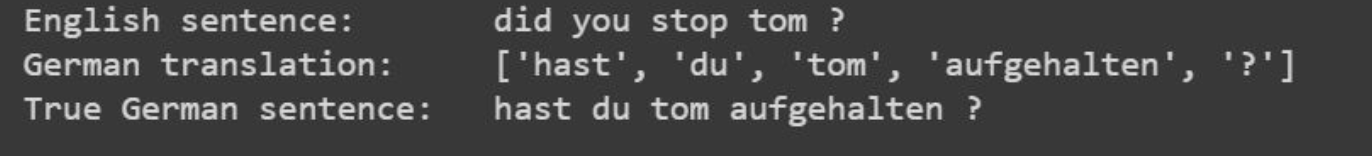

In [4]:
Image("/content/gdrive/MyDrive/TensorFlow/English-German/example1.png")

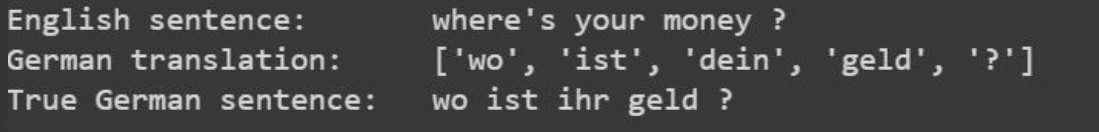

In [5]:
Image("/content/gdrive/MyDrive/TensorFlow/English-German/example2.png")

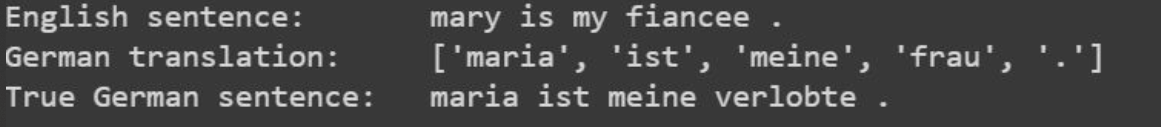

In [6]:
Image("/content/gdrive/MyDrive/TensorFlow/English-German/example3.png")

### Let's get started!

We'll start by running some imports, and loading the dataset. We wil work with tensorflow and we will create and customize our model architectures,.

In [2]:

import tensorflow as tf
import tensorflow_hub as hub
import unicodedata
import re
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Layer, concatenate, Input, Masking, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from IPython.display import Image


In [3]:
#Mount our google drive for the dataset
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive




For this project, we will use a language dataset from http://www.manythings.org/anki/ to build a neural translation model. This dataset consists of over 200,000 pairs of sentences in English and German. In order to make the training quicker, we will restrict to our dataset to 50,000 pairs. Feel free to change this if you wish.

Your goal is to develop a neural translation model from English to German, making use of a pre-trained English word embedding module.

In [ ]:
# Run this cell to load the dataset

NUM_EXAMPLES = 50000
data_examples = []
with open('/content/gdrive/MyDrive/TensorFlow/English-German/data/deu.txt', 'r', encoding='utf8') as f:
    for line in f.readlines():
        if len(data_examples) < NUM_EXAMPLES:
            data_examples.append(line)
        else:
            break

In [ ]:
# These functions preprocess English and German sentences

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"ü", 'ue', sentence)
    sentence = re.sub(r"ä", 'ae', sentence)
    sentence = re.sub(r"ö", 'oe', sentence)
    sentence = re.sub(r'ß', 'ss', sentence)

    sentence = unicode_to_ascii(sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-z?.!,']+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    return sentence.strip()

#### The custom translation model
The following is a schematic of the custom translation model architecture we will develop in this project.


The custom model consists of an encoder RNN and a decoder RNN. The encoder takes words of an English sentence as input, and uses a pre-trained word embedding to embed the words into a 128-dimensional space. To indicate the end of the input sentence, a special end token (in the same 128-dimensional space) is passed in as an input. This token is a TensorFlow Variable that is learned in the training phase (unlike the pre-trained word embedding, which is frozen).

The decoder RNN takes the internal state of the encoder network as its initial state. A start token is passed in as the first input, which is embedded using a learned German word embedding. The decoder RNN then makes a prediction for the next German word, which during inference is then passed in as the following input, and this process is repeated until the special `<end>` token is emitted from the decoder.

Don´t worry, this process will be explained step by step as we move forward.

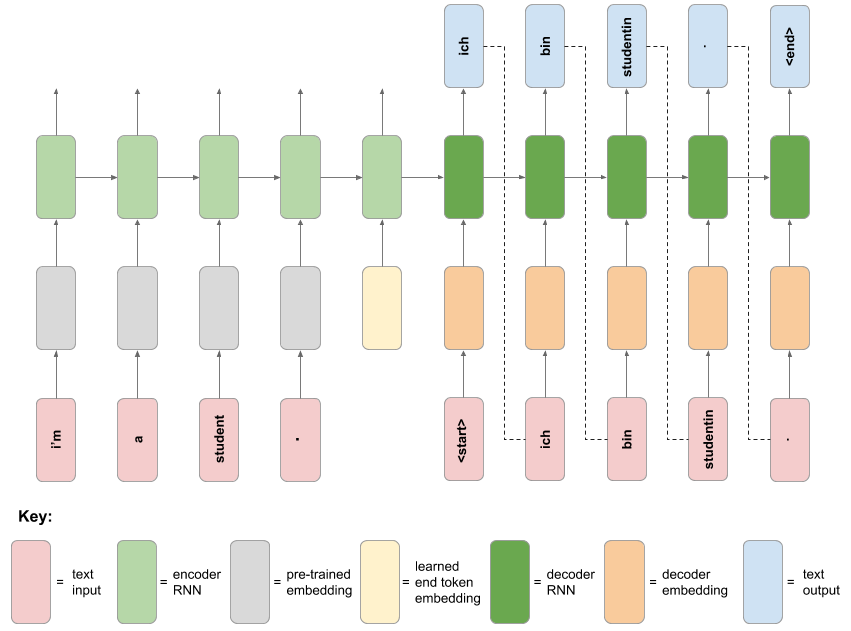

In [ ]:

!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1XsS1VlXoaEo-RbYNilJ9jcscNZvsSPmd"
Image("neural_translation_model.png")

## 1. Text preprocessing
* We will start by creating a separate lists of English and German sentences, and preprocess them using the `preprocess_sentence` function.
* Add a special `"<start>"` and `"<end>"` token to the beginning and end of every German sentence. This token will help the model to delimit each sentence in the dataset,
* Use the Tokenizer class from the `tf.keras.preprocessing.text` module to tokenize the German sentences, ensuring that no character filters are applied. This class will help us to tokenize each word in the dataset to a token (number).
* Pad the end of the tokenized German sequences with zeros, and batch the complete set of sequences into one numpy array. Padding this tokenized sequences will maintain each element (sentence) in our dataset with the same size.

In [ ]:
#Create separate lists of English and German sentences,
#and preprocess them using the preprocess_sentence function provided for you above.
english_examples = [preprocess_sentence(example.split('\t')[0]) for example in data_examples]
german_examples = [preprocess_sentence(example.split('\t')[1]) for example in data_examples]
german_examples= ["<start> " + sentence + " <end>" for sentence in german_examples]


In [ ]:
#Use the Tokenizer class from the tf.keras.preprocessing.text module to tokenize the German sentences,
#ensuring that no character filters are applied.
german_sequences=[]
tokenizer = Tokenizer(num_words=None,filters='',lower=True)
tokenizer.fit_on_texts(german_examples)
# Get the word index mapping, this index correlate each word with their respective token
word_index_german = tokenizer.word_index
german_sequences = tokenizer.texts_to_sequences(german_examples)

In [ ]:
#This function help us to find the sentences with the max number of words and characters
def max_len_finder(input_list):
    max_length = 0
    i=0
    for item in input_list:
        i=i+1
        curr_len = len(item)
        if max_length < curr_len:
            max_length = curr_len
            y=i-1
    return max_length,y

In [ ]:
#We will print out 5 examples of english sentences, their translation to german, and the tokenize sequence.
random_indexes = np.random.choice(len(german_examples), size=5, replace=False)
for i in random_indexes:
    print("English:",english_examples[i] )
    print("German (with tokens):", german_examples[i])
    print("Tokenized Sequence:", german_sequences[i])
    print()

English: i know why tom is here .
German (with tokens): <start> ich weiss , warum tom hier ist . <end>
Tokenized Sequence: [1, 4, 69, 15, 63, 5, 37, 6, 3, 2]

English: give me the ball .
German (with tokens): <start> gib mir den ball ! <end>
Tokenized Sequence: [1, 139, 21, 46, 779, 13, 2]

English: was it good ?
German (with tokens): <start> war es gut ? <end>
Tokenized Sequence: [1, 26, 11, 51, 7, 2]

English: don't scream .
German (with tokens): <start> schrei nicht ! <end>
Tokenized Sequence: [1, 1887, 10, 13, 2]

English: keep your room clean .
German (with tokens): <start> halte dein zimmer sauber . <end>
Tokenized Sequence: [1, 428, 94, 202, 703, 3, 2]



In [ ]:
#Now we will print the same as the previous cell, just with the padded tokenize sequence
vocab_size = max(word_index_german.values()) + 1
  # Pad the inputs to the maximum length using maxlen
max_len,max_item = max_len_finder(german_sequences)
  # create numpy array with padded sequences
padded_german_sequences = tf.keras.preprocessing.sequence.pad_sequences(german_sequences,maxlen=13,
                                                                          padding='post',)
random_indexes = np.random.choice(len(german_examples), size=5, replace=False)
for i in random_indexes:
    print("English:",english_examples[i] )
    print("German (with tokens):", german_examples[i])
    print("Tokenized Sequence:", padded_german_sequences[i])
    print()

print("Max item is",max_item)
print("English:",english_examples[max_item] )
print("German (with tokens):", german_examples[max_item])
print("Tokenized Sequence:", padded_german_sequences[max_item])


English: tom is in boston now .
German (with tokens): <start> tom ist jetzt in boston . <end>
Tokenized Sequence: [  1   5   6  70  41 183   3   2   0   0   0   0   0]

English: i have to hide .
German (with tokens): <start> ich muss mich verstecken . <end>
Tokenized Sequence: [   1    4   71   24 1308    3    2    0    0    0    0    0    0]

English: you're hurting me .
German (with tokens): <start> du tust mir weh ! <end>
Tokenized Sequence: [   1   12 1127   21  265   13    2    0    0    0    0    0    0]

English: we're not dating .
German (with tokens): <start> wir gehen nicht miteinander aus . <end>
Tokenized Sequence: [   1   17   55   10 1577   43    3    2    0    0    0    0    0]

English: didn't i say that ?
German (with tokens): <start> habe ich es nicht gesagt ? <end>
Tokenized Sequence: [  1  19   4  11  10 157   7   2   0   0   0   0   0]

Max item is 37757
English: mary is a soccer mom .
German (with tokens): <start> maria ist als mutter fast ausschliesslich damit be

In [ ]:
#This is the number of words unique words  and characters in our dataset
print(vocab_size)

10459


## 2. Prepare the data with tf.data.Dataset objects

#### Load the embedding layer
As part of the dataset preproceessing for this project, we will use a pre-trained English word embedding module from TensorFlow Hub. The URL for the module is https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1.

This embedding takes a batch of text tokens in a 1-D tensor of strings as input. It then embeds the separate tokens into a 128-dimensional space.

**NB:** this model can also be used as a sentence embedding module. The module will process each token by removing punctuation and splitting on spaces. It then averages the word embeddings over a sentence to give a single embedding vector. However, we will use it only as a word embedding module, and will pass each word in the input sentence as a separate token.

In [ ]:
# Load embedding module from Tensorflow Hub

embedding_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1",
                                 output_shape=[128], input_shape=[], dtype=tf.string)

In [ ]:
# Test the layer
# The TensorShape has a dimension of 128 for each token
embedding_layer(tf.constant(["these", "aren't", "the", "droids", "you're", "looking", "for"])).shape

TensorShape([7, 128])

We will now prepare the training and validation Datasets.

* Create a random training and validation set split of the data, reserving e.g. 20% of the data for validation (NB: each English dataset example is a single sentence string, and each German dataset example is a sequence of padded integer tokens).
* Load the training and validation sets into a tf.data.Dataset object, passing in a tuple of English and German data for both training and validation sets.
* Create a function to map over the datasets that splits each English sentence at spaces.
* Create a function to map over the datasets that embeds each sequence of English words using the loaded embedding layer/model. Apply this function to both Dataset objects using the map method.
* Create a function to filter out dataset examples where the English sentence is more than 13 (embedded) tokens in length. Apply this function to both Dataset objects using the filter method.
* Create a function to map over the datasets that pads each English sequence of embeddings with some distinct padding value before the sequence, so that each sequence is length 13. Apply this function to both Dataset objects using the map method.
* Batch both training and validation Datasets with a batch size of 16.


In [ ]:
#Split the dataset in train and validation
train_english, val_english, train_german, val_german = train_test_split(english_examples,padded_german_sequences, test_size=0.2,random_state=42)
print(len(train_english))
print(len(val_english))
print(len(train_german))
print(len(val_german))

40000
10000
40000
10000


In [ ]:
#Load the training and validation sets into a tf.data.Dataset object, passing in a tuple of English and German
#data for both training and validation sets.
train_dataset = tf.data.Dataset.from_tensor_slices((train_english, train_german))
val_dataset = tf.data.Dataset.from_tensor_slices((val_english, val_german))


In [ ]:
#Create a function to map over the datasets that splits each English sentence at spaces.
#Apply this function to both Dataset objects using the map method. Hint: look at the tf.strings.split function.
def split_sentence(sentence,german_sentences):
    split_sentence = tf.strings.split(sentence, sep=' ')
    return split_sentence,german_sentences


In [ ]:
#Create a function to map over the datasets that embeds each sequence of English words using the loaded embedding
#layer/model. Apply this function to both Dataset objects using the map method.
def embedded_sentences(sentence,german_sentences):
    embedded= embedding_layer(sentence)
    return embedded,german_sentences

In [ ]:
#Create a function to filter out dataset examples where the English sentence is more than 13 (embedded) tokens in length.
#Apply this function to both Dataset objects using the filter method.
def embedded_filter(sentence,german_sentences):
    return tf.math.less(tf.cast(tf.shape(sentence)[0],dtype=tf.int32), 13)

In [ ]:
#Create a function to map over the datasets that pads each English sequence of embeddings
#with some distinct padding value before the sequence, so that each sequence is length 13.
def pad_sequence(sentences,german_sentences):
    pad_value = [[13 - len(sentences), 0], [0, 0]]
    embeded_english_padded = tf.pad(sentences, pad_value)
    return embeded_english_padded, german_sentences



In [ ]:
#Apply all the functions defined above for each dataset
def preprocess_dataset(dataset):
  dataset = dataset.map(split_sentence)
  dataset=dataset.map(embedded_sentences)
  dataset=dataset.filter(embedded_filter)
  dataset=dataset.map(pad_sequence)
  dataset = dataset.batch(16, drop_remainder=True)
  return dataset
train_dataset = preprocess_dataset(train_dataset)
val_dataset= preprocess_dataset(val_dataset)


In [ ]:
#This is the Spec for each of the datasets, as can be seen is divided in batchs of 16 and of dimension 128 for each token.
#And its limited only to 13 embedded tokens per sentence.
print(train_dataset.element_spec)
print(val_dataset.element_spec)


(TensorSpec(shape=(16, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(16, 13), dtype=tf.int32, name=None))
(TensorSpec(shape=(16, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(16, 13), dtype=tf.int32, name=None))


In [ ]:
#Now we can print out an example of a batch in the each dataset.
for english_train_example, german_train_example in train_dataset.take(1):
    print("Shape of English Training Example: ", english_train_example.shape)
    print(german_train_example)
# get the shape for a german sequence example in the validation dataset
for english_val_example, german_val_example in val_dataset.take(1):
    print("Shape of German Validation Example: ", german_val_example.shape)
    print(german_val_example)

Shape of English Training Example:  (16, 13, 128)
tf.Tensor(
[[   1    5  107   92  906    3    2    0    0    0    0    0    0]
 [   1    4  177  391    3    2    0    0    0    0    0    0    0]
 [   1  108  656  109   56    5    3    2    0    0    0    0    0]
 [   1    5 4983   48    3    2    0    0    0    0    0    0    0]
 [   1   16    5   11  108  157    7    2    0    0    0    0    0]
 [   1  101   27  317    7    2    0    0    0    0    0    0    0]
 [   1 3494   15   66    3    2    0    0    0    0    0    0    0]
 [   1    5 1421   10    3    2    0    0    0    0    0    0    0]
 [   1    4 1450   24   10  115   46 1024    3    2    0    0    0]
 [   1   14 5267  239 1750    3    2    0    0    0    0    0    0]
 [   1    5    6  508    3    2    0    0    0    0    0    0    0]
 [   1    4 1488   10    5    3    2    0    0    0    0    0    0]
 [   1   35  236   11   49  340 1142  317    7    2    0    0    0]
 [   1    4   19 1110  441  134    3    2    0    0    

## 3. Create the custom layer
You will now create a custom layer to add the learned end token embedding to the encoder model:

We wil create a custom layer that adds a token at the end of each sequence, this embeddded token will be trained.

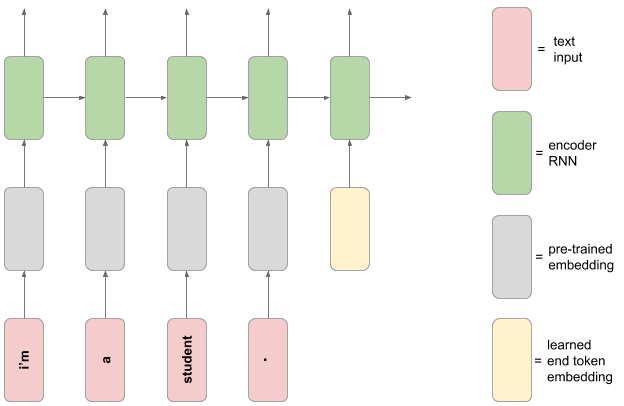

In [ ]:
!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1JrtNOzUJDaOWrK4C-xv-4wUuZaI12sQI"
Image("neural_translation_model.png")

Now we build the custom layer.
* Using layer subclassing, create a custom layer that takes a batch of English data examples from one of the Datasets, and adds a learned embedded ‘end’ token to the end of each sequence.
* This layer should create a TensorFlow Variable (that will be learned during training) that is 128-dimensional (the size of the embedding space).
* Using the Dataset `.take(1)` method, extract a batch of English data examples from the training Dataset and print the shape. Test the custom layer by calling the layer on the English data batch Tensor and print the resulting Tensor shape (the layer should increase the sequence length by one).

In [ ]:
class custom_layers(Layer):
    def __init__(self, **kwargs):
        super(custom_layers, self).__init__(**kwargs)
        self.token = tf.Variable(initial_value=tf.random.uniform(shape=(128,)),
                                   trainable=True)
    def call(self, inputs):
        end_embed_token = tf.tile(tf.reshape(self.token, shape=(1, 1, tf.shape(self.token)[0])),
                         [tf.shape(inputs)[0], 1, 1])
        concat_input = concatenate([inputs, end_embed_token], axis=1)
        return concat_input

In [ ]:
#Here we will use the coustom layer defined above in a batch example of the dataset, as can be seen the len of the tokens
#changes from 13 to 14, due to the embedded token added.
for english, german in train_dataset.take(1):
    print(f"initial english shape: {english.shape}")
    result = custom_layers()(english)
    print(f"After Learned Embedded Layer: {result.shape}")


initial english shape: (16, 13, 128)
After Learned Embedded Layer: (16, 14, 128)


## 4. Build the encoder network
The encoder network follows the schematic diagram above. Now we will build the RNN encoder model.
* Using the functional API, build the encoder network according to the following spec:
    * The model will take a batch of sequences of embedded English words as input, as given by the Dataset objects.
    * The next layer in the encoder will be the custom layer you created previously, to add a learned end token embedding to the end of the English sequence.
    * This is followed by a Masking layer, with the `mask_value` set to the distinct padding value you used when you padded the English sequences with the Dataset preprocessing above.
    * The final layer is an LSTM layer with 512 units, which also returns the hidden and cell states.
    * The encoder is a multi-output model. There should be two output Tensors of this model: the hidden state and cell states of the LSTM layer. The output of the LSTM layer is unused.


In [ ]:
#Define encoder model
def RNN_Encoder_Model(input_shape):
    inputs=Input(shape=input_shape)
    custom=custom_layers()(inputs)
    masking=Masking(mask_value=0)(custom)
    LSTM_layer,hidden,cell_state=LSTM(512,return_state=True)(masking)
    output=Model(inputs=inputs,outputs=[hidden,cell_state])
    return output


In [ ]:
 #Call the encoder model function, and create a encoder of 13 token in 128 dimensions
 #then we pass in a batch to the encoder and see the shape and summary of our encoder RNN model.
 model_rnn_encoder=RNN_Encoder_Model(input_shape=(13,128))
for english, german in train_dataset.take(1):
    hidden,cell_state=model_rnn_encoder(english)
    print(hidden.shape)
    print(cell_state.shape)
    model_rnn_encoder.summary()

(16, 512)
(16, 512)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13, 128)]         0         
                                                                 
 custom_layers_1 (custom_lay  (None, 14, 128)          128       
 ers)                                                            
                                                                 
 masking (Masking)           (None, 14, 128)           0         
                                                                 
 lstm (LSTM)                 [(None, 512),             1312768   
                              (None, 512),                       
                              (None, 512)]                       
                                                                 
Total params: 1,312,896
Trainable params: 1,312,896
Non-trainable params: 0
_______________________________

## 5. Build the decoder network
The decoder network follows the schematic diagram below.

This decoder model network will now create a encoder embedded layer, then we will use a LSTM layer, where we will obtain the hidden and cell state (this states will serve as input in each token, the same as the encoder output), and finally a dense layer with the number of units equal to the number of unique tokens in our dataste.

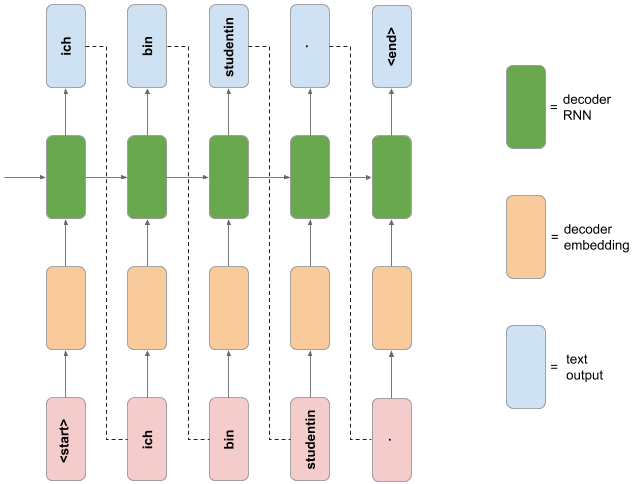

In [ ]:

!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1DTeaXD8tA8RjkpVrB2mr9csSBOY4LQiW"
Image("neural_translation_model.png")

We will now build the RNN decoder model.
* Using Model subclassing, build the decoder network according to the following spec:
    * The initializer should create the following layers:
        * An Embedding layer with vocabulary size set to the number of unique German tokens, embedding dimension 128, and set to mask zero values in the input.
        * An LSTM layer with 512 units, that returns its hidden and cell states, and also returns sequences.
        * A Dense layer with number of units equal to the number of unique German tokens, and no activation function.
    * The call method should include the usual `inputs` argument, as well as the additional keyword arguments `hidden_state` and `cell_state`. The default value for these keyword arguments should be `None`.
    * The call method should pass the inputs through the Embedding layer, and then through the LSTM layer. If the `hidden_state` and `cell_state` arguments are provided, these should be used for the initial state of the LSTM layer.
    * The call method should pass the LSTM output sequence through the Dense layer, and return the resulting Tensor, along with the hidden and cell states of the LSTM layer.
* Using the Dataset `.take(1)` method, extract a batch of English and German data examples from the training Dataset. Test the decoder model by first calling the encoder model on the English data Tensor to get the hidden and cell states, and then call the decoder model on the German data Tensor and hidden and cell states, and print the shape of the resulting decoder Tensor outputs.


In [ ]:
class Decoder_Model(Model):

    def __init__(self,**kwargs):
        super(Decoder_Model, self).__init__(**kwargs)
        self.embedded_layer=Embedding(vocab_size,128,mask_zero=True)
        self.LSTM_layer=LSTM(512,return_sequences=True, return_state=True)
        self.dense=Dense(vocab_size)
    def call (self,inputs,hidden_state=None,cell_state=None):
        embedded=self.embedded_layer(inputs)
        lstm,hidden,cell=self.LSTM_layer(embedded,initial_state=[hidden_state,cell_state])
        output=self.dense(lstm)
        return output,hidden,cell

In [ ]:
#We first call the Decoder model, then we take a batch and we call our encoder model into the english tokens
# from the encoder we exctract the hidden and cell state and pass in to the decoder with the german token.

model_decoder=Decoder_Model()
for english, german in train_dataset.take(1):
    hidden_encoder,cell_state_encoder=model_rnn_encoder(english)
    model,hidden_state_decoder,cell_state_decoder=model_decoder(german,hidden_encoder,cell_state_encoder)
    print(model.shape)
    print(hidden_state_decoder.shape)
    print(cell_state_decoder.shape)
    model_decoder.summary()

(16, 13, 10459)
(16, 512)
(16, 512)
Model: "decoder__model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  1338752   
                                                                 
 lstm_1 (LSTM)               multiple                  1312768   
                                                                 
 dense (Dense)               multiple                  5365467   
                                                                 
Total params: 8,016,987
Trainable params: 8,016,987
Non-trainable params: 0
_________________________________________________________________


## 6. Make a custom training loop
We will no write a custom training loop to train our custom neural translation model.
* Define a function that takes a Tensor batch of German data (as extracted from the training Dataset), and returns a tuple containing German inputs and outputs for the decoder model (refer to schematic diagram above).
* Define a function that computes the forward and backward pass for your translation model. This function should take an English input, German input and German output as arguments, and should do the following:
    * Pass the English input into the encoder, to get the hidden and cell states of the encoder LSTM.
    * These hidden and cell states are then passed into the decoder, along with the German inputs, which returns a sequence of outputs (the hidden and cell state outputs of the decoder LSTM are unused in this function).
    * The loss should then be computed between the decoder outputs and the German output function argument.
    * The function returns the loss and gradients with respect to the encoder and decoder’s trainable variables.
    * Decorate the function with @tf.function
* Define and run a custom training loop for a number of epochs (for you to choose) that does the following:
    * Iterates through the training dataset, and creates decoder inputs and outputs from the German sequences.
    * Updates the parameters of the translation model using the gradients of the function above and an optimizer object.
    * Every epoch, compute the validation loss on a number of batches from the validation and save the epoch training and validation losses.

This model is computationally demanding to train.

In [ ]:
#Slice over the dataset to obtain the 0/-1 to 1/:
def german_preprocess(dataset):
    inputs = dataset[:,:-1]
    output = dataset[:,1:]
    return inputs,output

In [ ]:
#Define the loss function and the optimizer that we will use for our model
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
#This function computes the backward and forward propagation in our model, we comput the gradient with the loss function
# and the loss value. We ad the @tf.function decorator, to improve the performance time of this computation.
@tf.function
def grad_fn(english,german_inp,german_out,loss):
    with tf.GradientTape() as tape:
        hidden_encoder,cell_state_encoder=model_rnn_encoder(english)
        outputs_decoder,hidden,cell=model_decoder(german_inp,hidden_encoder,cell_state_encoder)

        loss_value =tf.math.reduce_mean(loss(german_out, outputs_decoder))
        grads=tape.gradient(loss_value, model_rnn_encoder.trainable_variables + model_decoder.trainable_variables)
    return loss_value,grads


In [ ]:
#This is the training loop, where we perform the computation of loss and grads, we apply this with the optimizer to update the trainable variables
#and we compute the loss, we iterate for each batch in the dataset and also for each epoch that we defined, in this case were 15 epochs.
#train_loss_results=[]
#val_loss_results=[]
num_epochs=5

for epoch in range (num_epochs):
    loss_batch = []
    for english,german in train_dataset:
        #optimize the model
        german_inp,german_out=german_preprocess(german)
        loss_value, grads= grad_fn(english,german_inp,german_out,loss_func)
        optimizer.apply_gradients(zip(grads,model_rnn_encoder.trainable_variables + model_decoder.trainable_variables))

            #compute current loss
        loss_batch += [loss_value]
    train_loss_results.append(np.mean(loss_batch))
       #Validation
    loss_batch = []
    for english,german in val_dataset:
        german_inp_val,german_out_val=german_preprocess(german)
        loss_value, grads= grad_fn(english,german_inp_val,german_out_val,loss_func)
            #compute current loss
        loss_batch += [loss_value]
    val_loss_results.append(np.mean(loss_batch))
    print('Epoch {:03d}: Train Loss:  {:.3f}, Val Loss {:.3f}'.format(epoch+15,train_loss_results[-1],val_loss_results[-1]))




Epoch 015: Train Loss:  1.442, Val Loss 2.030
Epoch 016: Train Loss:  1.383, Val Loss 2.003
Epoch 017: Train Loss:  1.329, Val Loss 1.977
Epoch 018: Train Loss:  1.274, Val Loss 1.951
Epoch 019: Train Loss:  1.223, Val Loss 1.930


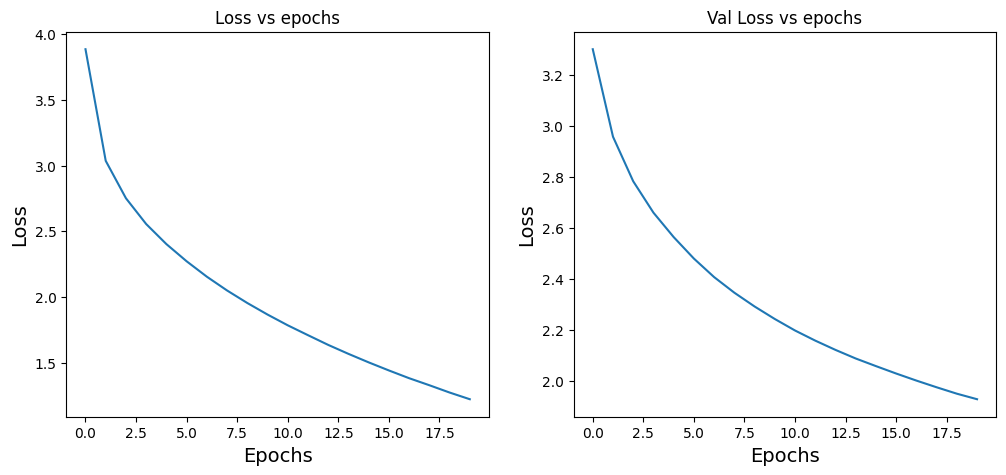

In [ ]:
#We can see the loss for the training and validation
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 5))

axes[0].set_xlabel("Epochs", fontsize=14)
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].set_title('Loss vs epochs')
axes[0].plot(train_loss_results)

axes[1].set_title('Val Loss vs epochs')
axes[1].set_ylabel("Loss", fontsize=14)
axes[1].set_xlabel("Epochs", fontsize=14)
axes[1].plot(val_loss_results)
plt.show()

## 7. Use the model to translate
Now it's time to put our model into practice!
 For each sentence, the process is as follows:
* Preprocess and embed the English sentence according to the model requirements.
* Pass the embedded sentence through the encoder to get the encoder hidden and cell states.
* Starting with the special  `"<start>"` token, use this token and the final encoder hidden and cell states to get the one-step prediction from the decoder, as well as the decoder’s updated hidden and cell states.
* Create a loop to get the next step prediction and updated hidden and cell states from the decoder, using the most recent hidden and cell states. Terminate the loop when the `"<end>"` token is emitted, or when the sentence has reached a maximum length.
* Decode the output token sequence into German text and print the English text and the model's German translation.

In [ ]:
#This function helps us to preprocess each english sentence for our model to predict
def translate_english_to_german(sentence):
    def preprocess_english_example(sentence):
      split_sentence = tf.strings.split(sentence)
      embedding_sentence = embedding_layer(split_sentence)
      pad_value =  [[tf.math.maximum(13-tf.shape(embedding_sentence)[0],0), 0], [0,0]]
      embedded_sen= tf.pad(embedding_sentence, pad_value)
      return embedded_sen

    english_input = preprocess_english_example(sentence)
    hidden, cell = model_rnn_encoder(tf.expand_dims(english_input, 0))
    german_word = tf.Variable([[tokenizer.word_index['<start>']]])
    german_sent = []

    while len(german_sent) < 15:
      decoder_outputs, hidden, cell = model_decoder(german_word, hidden, cell)
      decoder_outputs = tf.squeeze(tf.argmax(decoder_outputs, axis=2)).numpy()
      if decoder_outputs == tokenizer.word_index['<end>']:
        break
      german_sent.append(tokenizer.index_word[decoder_outputs])
      german_word = tf.Variable([[decoder_outputs]])
    print(f'English sentence:\t{sentence}')
    print(f'German translation:\t{german_sent}')


In [ ]:
#We select 3 random examples and we print out the sentence and its prediction.
sample_index = np.random.choice(len(german_examples), size=5, replace=False)
german_sentences_example = [preprocess_sentence(data.split("\t")[1]) for data in data_examples]

for i in sample_index:
    english_sentences_example = [preprocess_sentence(data.split("\t")[0]) for data in data_examples]
    sentence = english_sentences_example[i]
    translate_english_to_german(sentence)
    print(f'True German sentence:\t{german_sentences_example[i]}\n')


English sentence:	where's your money ?
German translation:	['wo', 'ist', 'dein', 'geld', '?']
True German sentence:	wo ist ihr geld ?

English sentence:	you stink .
German translation:	['du', 'hast', 'gemogelt', '.']
True German sentence:	du stinkst .

English sentence:	tom got nothing .
German translation:	['tom', 'hat', 'nichts', '.']
True German sentence:	tom bekam nichts .

English sentence:	mary is my fiancee .
German translation:	['maria', 'ist', 'meine', 'frau', '.']
True German sentence:	maria ist meine verlobte .

English sentence:	can i open the window ?
German translation:	['kann', 'ich', 'den', 'fernseher', 'ausschalten', '?']
True German sentence:	kann ich das fenster oeffnen ?

